In [1]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt

In [2]:
#parameters
t_1 = 0.425
t_2 = 0.05
t_3 = -0.025
t_4 = -0.075
kB = 8.617e-5
T=0.1

# k-grid
n_k = 100
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

In [3]:
def epsilon(k_x,k_y,t_1,t_2,t_3,mu,epsi):
    return -2*t_2*((1-epsi)*np.cos(k_x)+(1+epsi)*np.cos(k_y))-4*t_3*(1-1/2*epsi**2)*np.cos(k_x)*np.cos(k_y)-mu

def tx(k_x,k_y,t_1,epsi):
    return -4*t_1*(1-1/2*epsi**2)*np.cos(k_x/2)*np.cos(k_y/2)

def tz(k_x,k_y,t_4,epsi):
    return 4*t_4*(1-1/2*epsi**2)*np.sin(k_x)*np.sin(k_y)

In [4]:


def dispersion(k_x,k_y,sigma,N,U,mu,beta,epsi):
    return epsilon(k_x,k_y,t_1,t_2,t_3,mu,epsi)+beta*np.sqrt(tx(k_x,k_y,t_1,epsi)**2+(tz(k_x,k_y,t_4,epsi)-U/2*sigma*N)**2)

def fermi(E, mu, T):
    if T == 0:
        return np.where(E < mu, 1.0, 0.0)
    else:
        x = (E - mu) / (kB * T)
        x = np.clip(x, -700, 700)
        return 1/ (np.exp(x) + 1)

def energy_split(k_x,k_y,N,U,mu,epsi):
    E_up_plus=dispersion(k_x,k_y,1,N,U,mu,1,epsi)
    E_up_minus=dispersion(k_x,k_y,1,N,U,mu,-1,epsi)
    E_down_plus=dispersion(k_x,k_y,-1,N,U,mu,1,epsi)
    E_down_minus=dispersion(k_x,k_y,-1,N,U,mu,-1,epsi)
    return E_up_plus,E_up_minus,E_down_plus,E_down_minus

def n_e(N,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, mu, T)
    f_up_minus = fermi(E_up_minus, mu, T)
    f_down_plus = fermi(E_down_plus, mu, T)
    f_down_minus = fermi(E_down_minus, mu, T)
    return 1/n_k**2 * np.sum(a(1, N, U)**2*f_up_plus+a(-1, N, U)**2 *f_down_plus+b(1, N, U)**2*f_up_minus+b(-1, N, U)**2*f_down_minus)

def density_difference(mu, N, U, n_target, T):
    n = n_e(N, U, mu, T,epsi)
    return n - n_target


In [5]:
#eigenvectors

def a(sigma, N, U):
    return 1/np.sqrt(2)*np.sqrt(1+(tz(KX,KY,t_4,epsi)-U/2*sigma*N)/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4,epsi)-U/2*sigma*N)**2))

def b(sigma, N, U):
    return -1/np.sqrt(2)*np.sqrt(1-(tz(KX,KY,t_4,epsi)-U/2*sigma*N)/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4,epsi)-U/2*sigma*N)**2))

In [6]:
#self consistency equation

def order_param(N,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, mu, T)
    f_up_minus = fermi(E_up_minus, mu, T)
    f_down_plus = fermi(E_down_plus, mu, T)
    f_down_minus = fermi(E_down_minus, mu, T)
    return 1/n_k**2 * np.sum(a(1, N, U)**2*f_up_plus-a(-1, N, U)**2 *f_down_plus+b(1, N, U)**2*f_up_minus-b(-1, N, U)**2*f_down_minus)


# calculation

In [7]:
#starting mu
n_0=1
N_0=0
U_0=1
epsi=0


try:
    mu_0 = brentq(density_difference, -10, 10, args=(N_0, U_0, n_0, T), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)

0.06392712190741723


In [11]:
x=0.3
mu_current=mu_0
U=1
N_current=1


for i in range(100):
    N_new=N_current*x+(1-x)*order_param(N_current,U,mu_current,T,0)
    n_current=n_e(N_new,U,mu_current,T,0)

    #mu_new=mu_current*n_current
    try:
        mu_new = brentq(density_difference, -10, 10, args=(N_new, U, 1, T), xtol=1e-5)
    except ValueError:
        print("mu not found")
    n_new=n_e(N_new,U,mu_new,T,0)  
        
    print(f"step {i+1}: N = {N_new:.3f}, mu = {mu_new:.3f}, n = {n_new:.3f}")

    if np.abs(N_new - N_current)+np.abs(n_new-1)<1e-4:
        print(f"Converged in {i+1} steps.")
        break

    N_current = N_new
    mu_current=mu_new

step 1: N = 0.749, mu = 0.137, n = 1.000
step 2: N = 0.621, mu = 0.105, n = 1.000
step 3: N = 0.548, mu = 0.087, n = 1.000
step 4: N = 0.504, mu = 0.031, n = 1.000
step 5: N = 0.476, mu = 0.035, n = 1.000
step 6: N = 0.459, mu = 0.065, n = 1.000
step 7: N = 0.447, mu = 0.062, n = 1.000
step 8: N = 0.440, mu = 0.060, n = 1.000
step 9: N = 0.435, mu = 0.045, n = 1.000
step 10: N = 0.431, mu = 0.058, n = 1.000
step 11: N = 0.429, mu = 0.057, n = 1.000
step 12: N = 0.427, mu = 0.057, n = 1.000
step 13: N = 0.426, mu = 0.057, n = 1.000
step 14: N = 0.426, mu = 0.046, n = 1.000
step 15: N = 0.425, mu = 0.056, n = 1.000
step 16: N = 0.425, mu = 0.055, n = 1.000
step 17: N = 0.425, mu = 0.055, n = 1.000
step 18: N = 0.424, mu = 0.056, n = 1.000
step 19: N = 0.424, mu = 0.046, n = 1.000
Converged in 19 steps.


Converged in 42 steps,U=0.85
Converged in 49 steps,U=0.88
Converged in 62 steps,U=0.92
Converged in 89 steps,U=0.95
Converged in 17 steps,U=0.99
Converged in 17 steps,U=1.02
Converged in 16 steps,U=1.06
Converged in 16 steps,U=1.09
Converged in 16 steps,U=1.13
Converged in 16 steps,U=1.16
Converged in 15 steps,U=1.20
Converged in 15 steps,U=1.23
Converged in 15 steps,U=1.27
Converged in 14 steps,U=1.30
[np.float64(0.0016798109323822759), np.float64(0.0019476163345738752), np.float64(0.002176494540305463), np.float64(0.0024393813845004697), np.float64(0.4185320783295821), np.float64(0.4355988609294707), np.float64(0.4522861211086288), np.float64(0.46845193863982093), np.float64(0.4841577407239472), np.float64(0.4993989584933512), np.float64(0.514227303034114), np.float64(0.5285310255494646), np.float64(0.5423758794207828), np.float64(0.555824706931515)]
Estimated critical interaction U_c where N ≈ 0: 0.95 meV


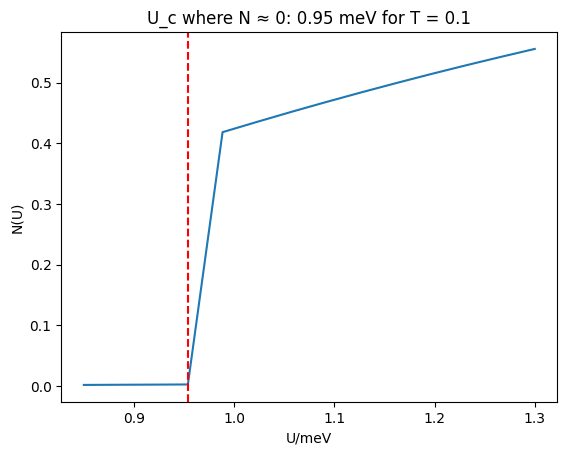

In [12]:
N_U=[]
x=0.2
U_max=1.3
U_min=0.85
n_U=14
epsi=0

for U in np.linspace(U_min,U_max,n_U):
    mu_current=mu_0
    N_current=1
    for i in range(100):
        N_new=N_current*x+(1-x)*order_param(N_current,U,mu_current,T,epsi)
        n_current=n_e(N_new,U,mu_current,T,epsi)

        #mu_new=mu_current*n_current
        try:
            mu_new = brentq(density_difference, -10, 10, args=(N_new, U, 1, T), xtol=1e-5)
        except ValueError:
            print("mu not found")
        n_new=n_e(N_new,U,mu_new,T,epsi)  
        
        #print(f"step {i+1}: N = {N_new:.3f}, mu = {mu_new:.3f}, n = {n_new:.3f}")

        if np.abs(N_new - N_current)+np.abs(n_new-1)<1e-4:
            print(f"Converged in {i+1} steps,U={U:.2f}")
            break

        N_current = N_new
        mu_current=mu_new
    N_U.append(N_new)
print(N_U)
N_U_array=np.array(N_U)
# Find critical temperature where W becomes nearly zero
epsilon = 1e-1
U_values = np.linspace(U_min, U_max, n_U)
N_U_array = np.array(N_U)

#Find first index where W < epsilon
try:
    idx = np.where(np.abs(N_U_array) > epsilon)[0][0]
    U_critical = U_values[idx-1]
    print(f"Estimated critical interaction U_c where N ≈ 0: {U_critical:.2f} meV")
except IndexError:
    print("N does not drop below threshold within U range.")
    U_critical = None

plt.plot(U_values, N_U_array, label='N(U)')
#if U_critical is not None:
 #   plt.axvline(U_critical, color='r', linestyle='--', label=f'U_c ≈ {U_critical:.1f} K')


#plt.plot(np.linspace(0,U_max,n_U),N_U_array, label='N(U)')
plt.axvline(U_critical, color='r', linestyle='--', label=f'U_c')
plt.xlabel('U/meV')
plt.ylabel('N(U)')
plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('N and U.png')
plt.show()

# $\epsilon$ dependence

Converged in 17 steps,U=0.00
Converged in 11 steps,U=0.03
Converged in 17 steps,U=0.07
Converged in 9 steps,U=0.10
Converged in 18 steps,U=0.13
Converged in 16 steps,U=0.17
Converged in 17 steps,U=0.20
Converged in 18 steps,U=0.23
Converged in 19 steps,U=0.27
Converged in 21 steps,U=0.30
[0.4242688286140781, 0.42402411702539705, 0.4152478104975735, 0.422370699223365, 0.40978004347670804, 0.4070429686322531, 0.4048270307352133, 0.4014330956833949, 0.39648965334028147, 0.3921344703476542]


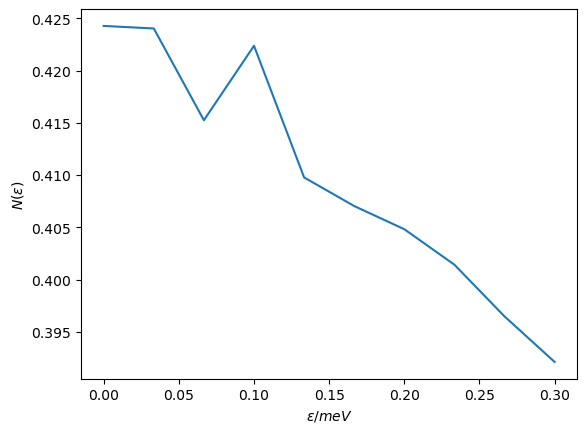

In [74]:
N_epsi=[]
x=0.2
U=1
e_max=0.3
e_min=0
n_epsi=10

for e in np.linspace(e_min,e_max,n_epsi):
    mu_current=mu_0
    N_current=1
    for i in range(100):
        N_new=N_current*x+(1-x)*order_param(N_current,U,mu_current,T,e)
        n_current=n_e(N_new,U,mu_current,T,e)

        #mu_new=mu_current*n_current
        try:
            mu_new = brentq(density_difference, -10, 10, args=(N_new, U, 1, T), xtol=1e-5)
        except ValueError:
            print("mu not found")
        n_new=n_e(N_new,U,mu_new,T,epsi)  
        
        #print(f"step {i+1}: N = {N_new:.3f}, mu = {mu_new:.3f}, n = {n_new:.3f}")

        if np.abs(N_new - N_current)+np.abs(n_new-1)<1e-4:
            print(f"Converged in {i+1} steps,U={e:.2f}")
            break

        N_current = N_new
        mu_current=mu_new
    N_epsi.append(N_new)
print(N_epsi)
N_epsi_array=np.array(N_epsi)
epsi_values = np.linspace(e_min, e_max, n_epsi)

plt.plot(epsi_values, N_epsi_array, label=r'$N(\epsilon)$')
plt.xlabel(r'$\epsilon/meV$')
plt.ylabel(r'$N(\epsilon)$')
#plt.xlim(0,310)
#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
#plt.savefig('N and epsi.png')
plt.show()